<a href="https://colab.research.google.com/github/earo12/Prophet-Repo/blob/visualization_branch_10ago/PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install meteostat
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from meteostat import Stations, Daily
from datetime import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Metología Prophet para pronósticos de series de tiempo
La metodología Prophet es usada  por Taylor y Letham (2018) [1]. Se utilizan tres componentes en el modelo: tendencia, estacionalidad y efecto de vacaciones (hollidays).
$$
Y_t=g_t+s_t+h_t+e_t
$$
Donde $g_t$  es la función de tendencia que modela cambios no periódicos en el valor de la serie de tiempo,
$s_t$  representa cambios periódicos (estacionalidad semanal y anual),
$h_t$  representa los efectos de las vacaciones.
La especificación Prophet es una clase de modelos de regresión con suavizadores (smoothers) potencialmente no lineales aplicados a la regresores

[1] Taylor, S. & Letham, Benjamin (2018). Forecasting at Scale. The American Statistician. (72)1, 37-45.

## Como primer paso, necesitamos el dataset:

In [3]:
# Buscar estaciones por nombre de ciudad
stations = Stations()
stations = stations.nearby(19.4326, -99.1332) # Coordenadas aproximadas de la Ciudad de México
station = stations.fetch(1) # Estación más cercana

In [4]:
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
76679,Mexico City Airport,MX,DIF,76679,MMMX,19.4333,-99.0833,2234.0,America/Mexico_City,1985-07-19,2024-08-10,2017-01-21,2022-04-25,1949-01-01,2021-01-01,5233.108662


In [5]:
# De aquí se datos diarios para la estación más cercana a la Ciudad de México
start = datetime(2020, 1, 1)
end = datetime(2024, 3, 11)

In [7]:
# Definimos la data en función de los valores de start y end:
data = Daily(station, start,end)
data = data.fetch()
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2020-01-01,17.4,13.0,24.0,NaN,NaN,171.0,15.8,NaN,1008.5,NaN
2020-01-02,16.9,14.0,21.0,NaN,NaN,161.0,18.5,NaN,1006.2,NaN
2020-01-03,16.3,12.0,23.0,NaN,NaN,127.0,11.6,NaN,1009.6,NaN
2020-01-04,12.4,7.0,18.0,NaN,NaN,19.0,8.7,NaN,1018.4,NaN
2020-01-05,12.4,3.0,21.0,NaN,NaN,22.0,7.9,NaN,1022.2,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-03-07,22.3,15.0,30.0,0.0,NaN,201.0,12.1,NaN,1011.0,NaN
2024-03-08,23.2,15.2,32.0,0.0,NaN,191.0,8.8,NaN,1010.3,NaN
2024-03-09,22.5,11.0,31.0,0.0,NaN,162.0,8.9,NaN,1008.9,NaN


### De aquí, podemos notar las siguientes nomenclaturas:
$tavg$: Temperatura media o promedio diaria.

$tmin$: Temperatura mínima registrada en un día.

$tmax$: Temperatura máxima registrada en un día.

$prcp$: Precipitación total en milímetros o pulgadas para el día. Incluye lluvia, nieve, granizo, etc.

$snow$: Cantidad de nieve caída, generalmente en milímetros o centímetros equivalentes de agua.

$wdir$: Dirección promedio del viento en grados, donde 0 grados significa - viento soplando desde el norte.

$wspd$: Velocidad promedio del viento en kilómetros por hora o millas por hora.

$wpgt$: Racha de viento máxima, que es la velocidad más alta alcanzada por un golpe de viento.

$pres$: Presión atmosférica al nivel de la estación.

$tsun$: Duración de la insolación, que es el tiempo durante el cual un lugar recibe luz solar directa, medido en minutos u horas

## Visualización de la data:

In [9]:
# Veamos primero, los valores nulos y cómo se distribuyen:
null_data = data.isnull().sum()
null_data

,0
tavg,0
tmin,0
tmax,0
prcp,876
snow,1532
wdir,0
wspd,0
wpgt,1532
pres,0
tsun,1532


In [10]:
# Podemos suavizar  los datos con un promedio móvil de 7 días
data_suavizada = data.rolling(window=7).mean()
# Así mismo, podemos suavizar los datos con un promedio móvil de 14 días
data_suavizada2 = data.rolling(window=14).mean()

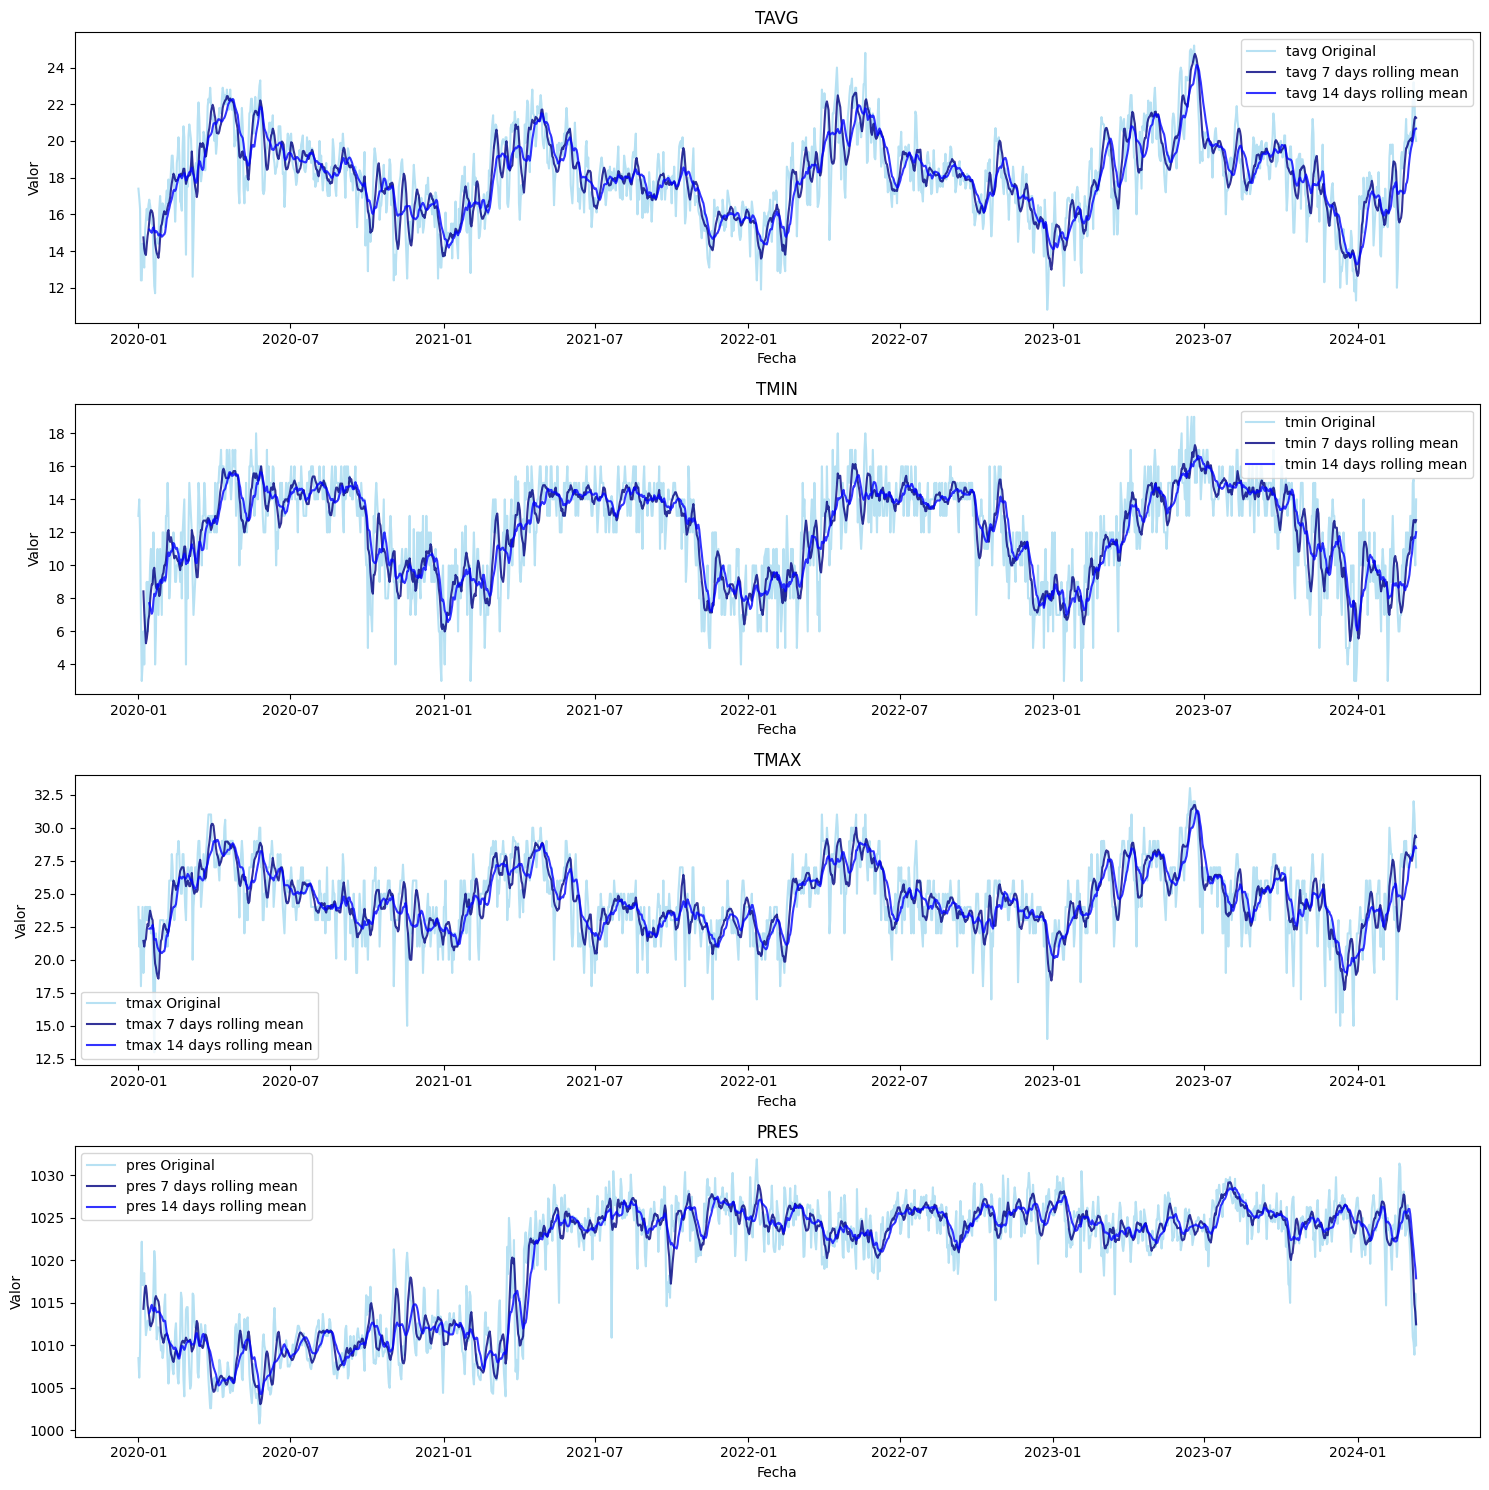

In [11]:
# Para graficar la data finalmente:
plt.figure(figsize=(15, 15))

variables = ['tavg', 'tmin', 'tmax', 'pres']

for i, var in enumerate(variables, 1):
    plt.subplot(4, 1, i)
    plt.plot(data.index, data[var], label=f'{var} Original', color='skyblue', alpha=0.6)
    plt.plot(data_suavizada.index, data_suavizada[var], label=f'{var} 7 days rolling mean', color='navy', alpha=0.8)
    plt.plot(data_suavizada2.index, data_suavizada2[var], label=f'{var} 14 days rolling mean', color='blue', alpha=0.8)
    plt.title(var.upper())
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()

plt.tight_layout()
plt.show()